<a href="https://colab.research.google.com/github/22ubeth/FP_KecerdasanBuatan/blob/main/FP_Kecerdasan_Buatan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Preprocessing

In [15]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing import image
import os
import zipfile


In [4]:
# Path ke file zip yang telah diunduh
dataset_path = "/content/dataset-rempah.zip"
extract_path = "/content/dataset-rempah"

# Fungsi untuk memverifikasi file zip dan mengekstrak isinya
def verify_and_extract_zip(file_path, extract_to):
    if not zipfile.is_zipfile(file_path):
        raise ValueError("File yang diunduh bukan zip file")

    # Pastikan direktori tujuan ada
    if not os.path.exists(extract_to):
        os.makedirs(extract_to)

    with zipfile.ZipFile(file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

# Ekstrak file zip
try:
    verify_and_extract_zip(dataset_path, extract_path)
except Exception as e:
    print(f"Error during extraction: {e}")

# Verifikasi isi direktori
dataset_dir = extract_path
print(f"Dataset directory contents: {os.listdir(dataset_dir)}")

# Pastikan subdirektori tidak kosong
for subdir in os.listdir(dataset_dir):
    subdir_path = os.path.join(dataset_dir, subdir)
    if os.path.isdir(subdir_path):
        print(f"Contents of {subdir_path}: {os.listdir(subdir_path)}")

Dataset directory contents: ['dataset-rempah']
Contents of /content/dataset-rempah/dataset-rempah: ['val', 'train', 'test']


## 2. Bangun Model CNN

In [24]:
# Inisialisasi model
model = Sequential()

# Layer 1: Convolution + ReLU
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)))
model.add(MaxPooling2D(pool_size=(3, 3)))

# Layer 2: Convolution + ReLU
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))

# Layer 3: Convolution + ReLU
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))

# Flattening
model.add(Flatten())

# Fully connected layer
model.add(Dense(units=128, activation='relu'))

# Output layer: Softmax
model.add(Dense(units=7, activation='softmax'))

# Kompilasi model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Data augmentation
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True, validation_split=0.2)

# Data training dan validation
train_generator = train_datagen.flow_from_directory('/content/dataset-rempah/dataset-rempah/train', target_size=(64, 64), batch_size=32, class_mode='categorical', subset='training')
validation_generator = train_datagen.flow_from_directory('/content/dataset-rempah/dataset-rempah/train', target_size=(64, 64), batch_size=32, class_mode='categorical', subset='validation')

# Training model
history = model.fit(train_generator, epochs=32, validation_data=validation_generator)

# Save model
model.save('spice_classifier.h5')


Found 138 images belonging to 7 classes.
Found 28 images belonging to 7 classes.
Epoch 1/32
5/5 [==============================] - 4s 679ms/step - loss: 1.9537 - accuracy: 0.1594 - val_loss: 1.9467 - val_accuracy: 0.1071
Epoch 2/32
5/5 [==============================] - 3s 603ms/step - loss: 1.9478 - accuracy: 0.1377 - val_loss: 1.9429 - val_accuracy: 0.1429
Epoch 3/32
5/5 [==============================] - 2s 409ms/step - loss: 1.9400 - accuracy: 0.1449 - val_loss: 1.9350 - val_accuracy: 0.1429
Epoch 4/32
5/5 [==============================] - 2s 465ms/step - loss: 1.9371 - accuracy: 0.1594 - val_loss: 1.9323 - val_accuracy: 0.1786
Epoch 5/32
5/5 [==============================] - 2s 471ms/step - loss: 1.9306 - accuracy: 0.1884 - val_loss: 1.9203 - val_accuracy: 0.2500
Epoch 6/32
5/5 [==============================] - 2s 389ms/step - loss: 1.9210 - accuracy: 0.2319 - val_loss: 1.9032 - val_accuracy: 0.2500
Epoch 7/32
5/5 [==============================] - 2s 555ms/step - loss: 1.9038 

##3. Evaluasi Model

Found 23 images belonging to 7 classes.
1/1 [==============================] - 0s 325ms/step - loss: 1.4293 - accuracy: 0.4348
Test accuracy: 0.43


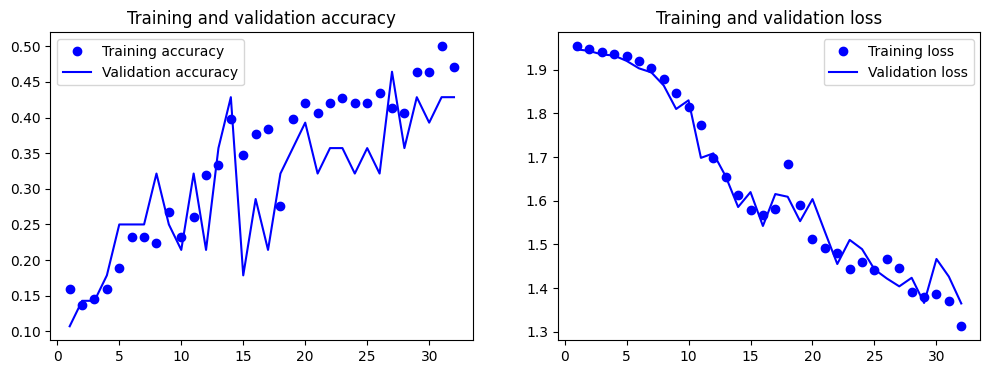

In [28]:
# Menggunakan model yang telah dilatih
model = tf.keras.models.load_model('spice_classifier.h5')

# Data testing
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory('/content/dataset-rempah/dataset-rempah/test', target_size=(64, 64), batch_size=32, class_mode='categorical')

# Evaluasi performa model
test_loss, test_acc = model.evaluate(test_generator)
print(f'Test accuracy: {test_acc:.2f}')

# Plot grafik akurasi dan loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


##4. Prediksi dengan Gambar Input

In [29]:
# Fungsi untuk memprediksi jenis rempah dari gambar input
def predict_spice(image_path):
    img = image.load_img(image_path, target_size=(64, 64))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.

    prediction = model.predict(img_array)
    class_names = ['Andaliman', 'Cabe jawa', 'Cengkeh', 'Kapulaga', 'Kayu manis', 'Lada', 'Pala']
    predicted_class = class_names[np.argmax(prediction)]
    return predicted_class

# Contoh penggunaan
image_path = '/content/kayu manis.jpg'
predicted_spice = predict_spice(image_path)
print(f'Predicted Spice: {predicted_spice}')


1/1 [==============================] - 0s 136ms/step
Predicted Spice: Pala
